In [17]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import FNO
from models.pfno import PNO_Wrapper, PFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import ERA5Dataset
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
import cmcrameri.cm as cmc
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

# Load best predictions

In [18]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

data_dir = "../../data/era5/"
checkpoint_path = "/home/groups/ai/scholl/pfno/weights/era5/fno/"

sr_dropout_path = checkpoint_path + "20240925_115247_era5_fno_sr_dropout/Datetime_20240925_115259_Loss_era5_FNO_scoring-rule-dropout_dropout_0.2.pt"
laplace_path = checkpoint_path + "20241008_125404_era5_fno_laplace/Datetime_20241008_125429_Loss_era5_FNO_laplace_dropout_0.01.pt"
dropout_path = checkpoint_path + "20240922_105401_era5_fno_dropout/Datetime_20240922_105416_Loss_era5_FNO_dropout_dropout_0.05.pt"
sr_reparam_path = checkpoint_path + "20240920_094424_era5_fno_sr_reparam/Datetime_20240920_094438_Loss_era5_FNO_scoring-rule-reparam_dropout_0.1.pt"

In [19]:
data_dir = "../../data/era5/"
test_data = ERA5Dataset(data_dir, var = "test")

lat,lon,t = test_data.get_coordinates(normalize = False)
L = test_data.get_domain_range()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

data_mean = test_data.mean
data_std = test_data.std
n_test = len(test_loader)

In [20]:
dropout_model = FNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = FNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.01, lifting_channels = 128, projection_channels=128).to(device)
la_model = LA_Wrapper(laplace_model)
la_model.load_state_dict(torch.load(laplace_path))
la_model.load_la_state_dict(torch.load(laplace_path[:-3] + "_la_state.pt"))

pfno_reparam = PFNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.1, lifting_channels = 128, projection_channels=128, n_samples = n_samples).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

sr_dropout_model = FNO(n_modes=(10,12, 12), hidden_channels=20, in_channels = 4, dropout=0.2, lifting_channels = 128, projection_channels=128).to(device)
sr_dropout_cp = torch.load(sr_dropout_path, map_location=torch.device(device))
pfno_dropout = PNO_Wrapper(sr_dropout_model, n_samples = n_samples)
pfno_dropout.load_state_dict(sr_dropout_cp)

<All keys matched successfully>

# Predictions

In [21]:
# Generate random samples for plotting
np.random.seed(42)
samples = np.random.randint(0,n_test,2)

In [22]:
pfno_dropout.train()
dropout_model.train()
pfno_reparam.eval()
""" Prediction """
pred_pfno_dropout = []
pred_pfno_reparam = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_dropout_pred = pfno_dropout(a, n_samples = n_samples)
        pfno_reparam_pred = pfno_reparam(a)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno_dropout.append( pfno_dropout_pred )
        pred_pfno_reparam.append( pfno_reparam_pred )
        pred_la.append( la_pred )


pred_pfno_dropout = torch.cat(pred_pfno_dropout, dim = 0).cpu().numpy()
pred_pfno_reparam = torch.cat(pred_pfno_reparam, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [23]:
def plot_statistics(truth, preds, names, grid, t, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth[:,:,t].squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = np.power((truth - pred_array.mean(axis = -1)),2).min(), vmax = np.power((truth - pred_array.mean(axis = -1)),2).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (20,10), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()},
                            layout = "constrained")

    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        
    for m, pred in enumerate(preds):        
        pred = pred[:,t].squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat, np.power((truth - pred.mean(axis = -1)),2), shading = "nearest", cmap = "cmc.vik", norm = mse_norm, rasterized = True)
        im2 = axs[1,m].pcolormesh(lon, lat,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla", norm = std_norm, rasterized = True)
        im3 = axs[2,m].pcolormesh(lon, lat,coverage, shading = "nearest", cmap = cmap_coverage, rasterized = True)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Standard deviation")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Standard deviation',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(3):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [24]:
def plot_predictions(truth, preds, names, grid, t, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth[:,:,t].squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    pred_norm = Normalize(vmin = pred_array.mean(axis = -1).min(), vmax = pred_array.mean(axis = -1).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(4, n_models, figsize = (20,14), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()},
                            layout = "constrained")

    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        
    for m, pred in enumerate(preds):        
        pred = pred[:,t].squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat ,truth, shading = "nearest", cmap = "cmc.vik", rasterized = True, norm = pred_norm)
        im1 = axs[1,m].pcolormesh(lon, lat ,pred.mean(axis = -1), shading = "nearest", cmap = "cmc.vik", norm = pred_norm, rasterized = True)
        im2 = axs[2,m].pcolormesh(lon, lat,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla", norm = std_norm, rasterized = True)
        im3 = axs[3,m].pcolormesh(lon, lat,coverage, shading = "nearest", cmap = cmap_coverage, rasterized = True)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Ground truth [K°]',size=title_size)
    cb1 = fig.colorbar(im1, ax = axs[1,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Prediction [K°]',size=title_size)
    cb3 = fig.colorbar(im2, ax = axs[2,m], label = "Standard deviation")
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label('Standard deviation',size=title_size)
    cb4 = fig.colorbar(im3, ax = axs[3,m], label = "", ticks = np.array([0,1]))
    cb4.ax.tick_params(labelsize=tick_size)
    cb4.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(4):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

# Plots

In [25]:
idx = 1

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx], pred_la[idx], pred_pfno_dropout[idx], pred_pfno_reparam[idx]]
names = ['Dropout', 'Laplace', 'PNO Dropout', 'PNO Reparam']

# Renormalize
preds = [pred*data_std + data_mean for pred in preds]
u = u*data_std + data_mean

Dropout- Coverage: 0.4178409090909091
Laplace- Coverage: 0.9032954545454546
PNO Dropout- Coverage: 0.9165625
PNO Reparam- Coverage: 0.6159659090909091


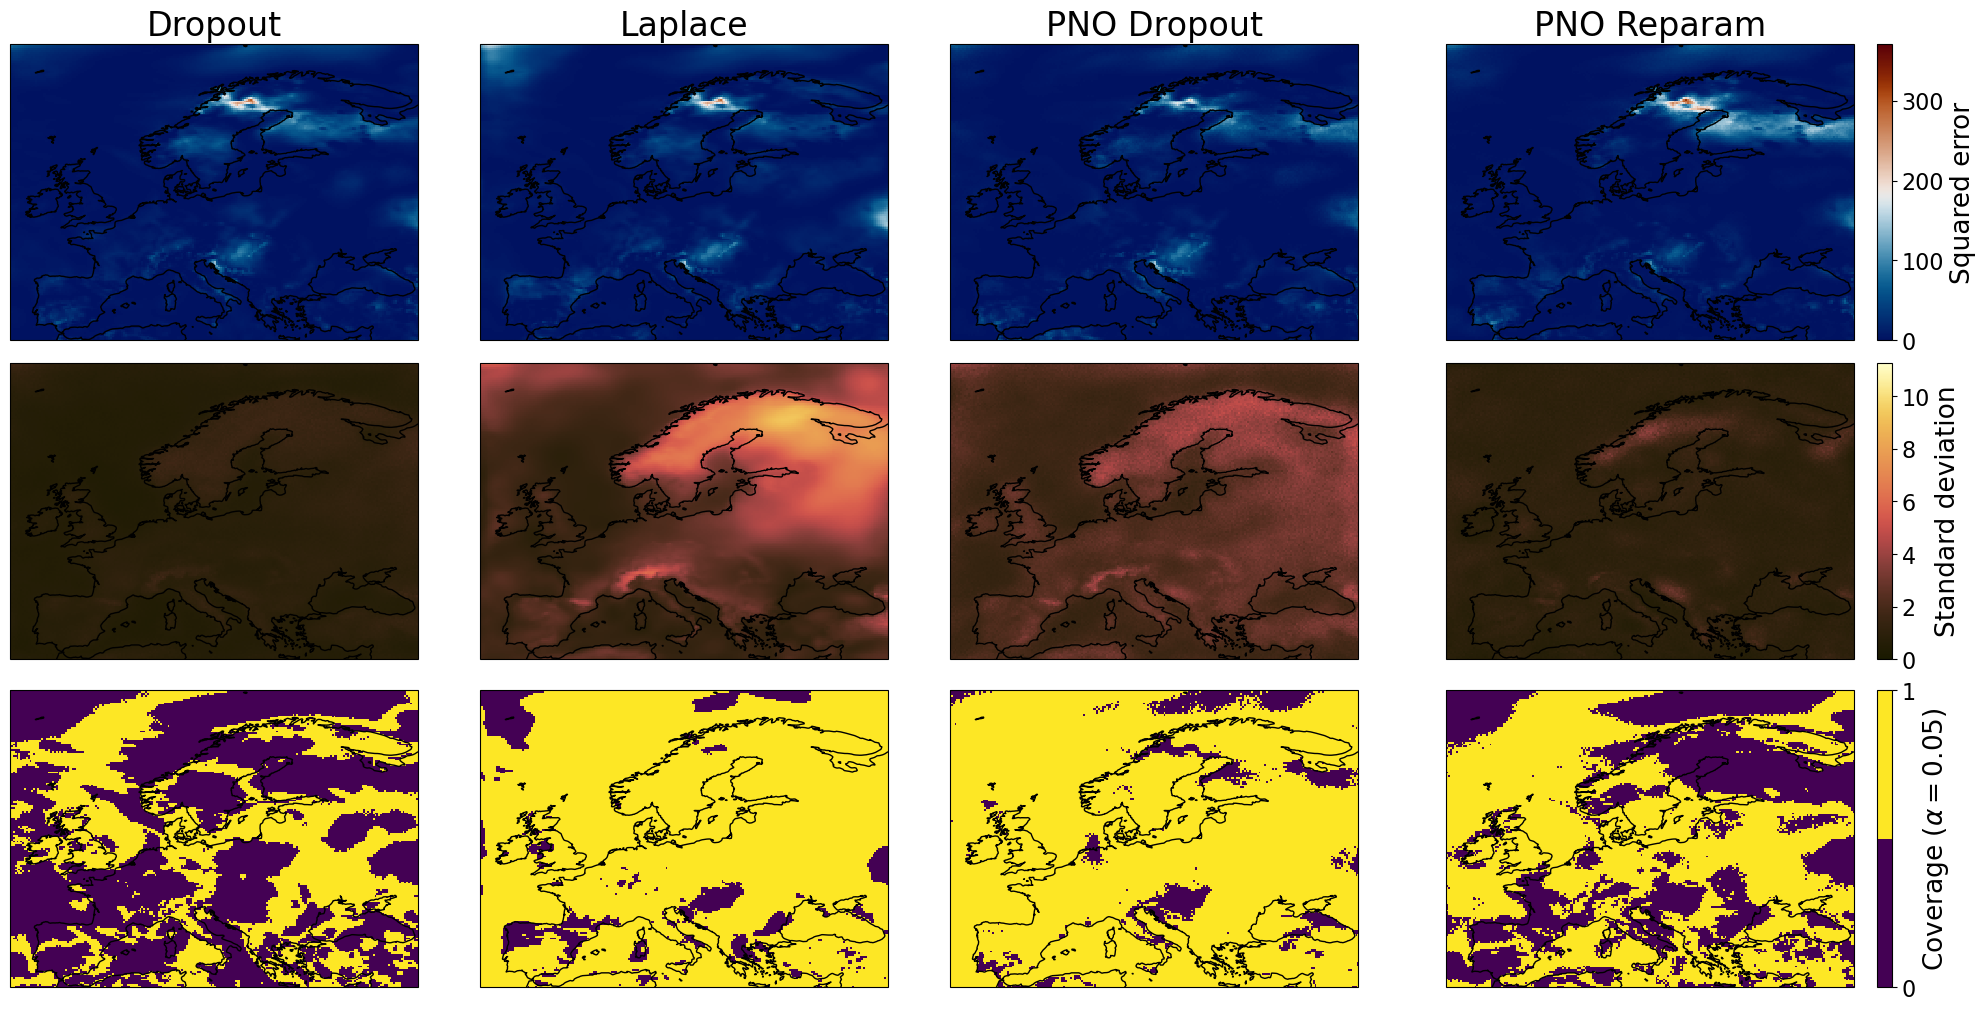

In [26]:
plot_statistics(u, preds, names, (lat,lon), t = 9, save_path = "plots/era5_statistics_10h.pdf", alpha = 0.05)

Dropout- Coverage: 0.4178409090909091
Laplace- Coverage: 0.9032954545454546
PNO Dropout- Coverage: 0.9165625
PNO Reparam- Coverage: 0.6159659090909091


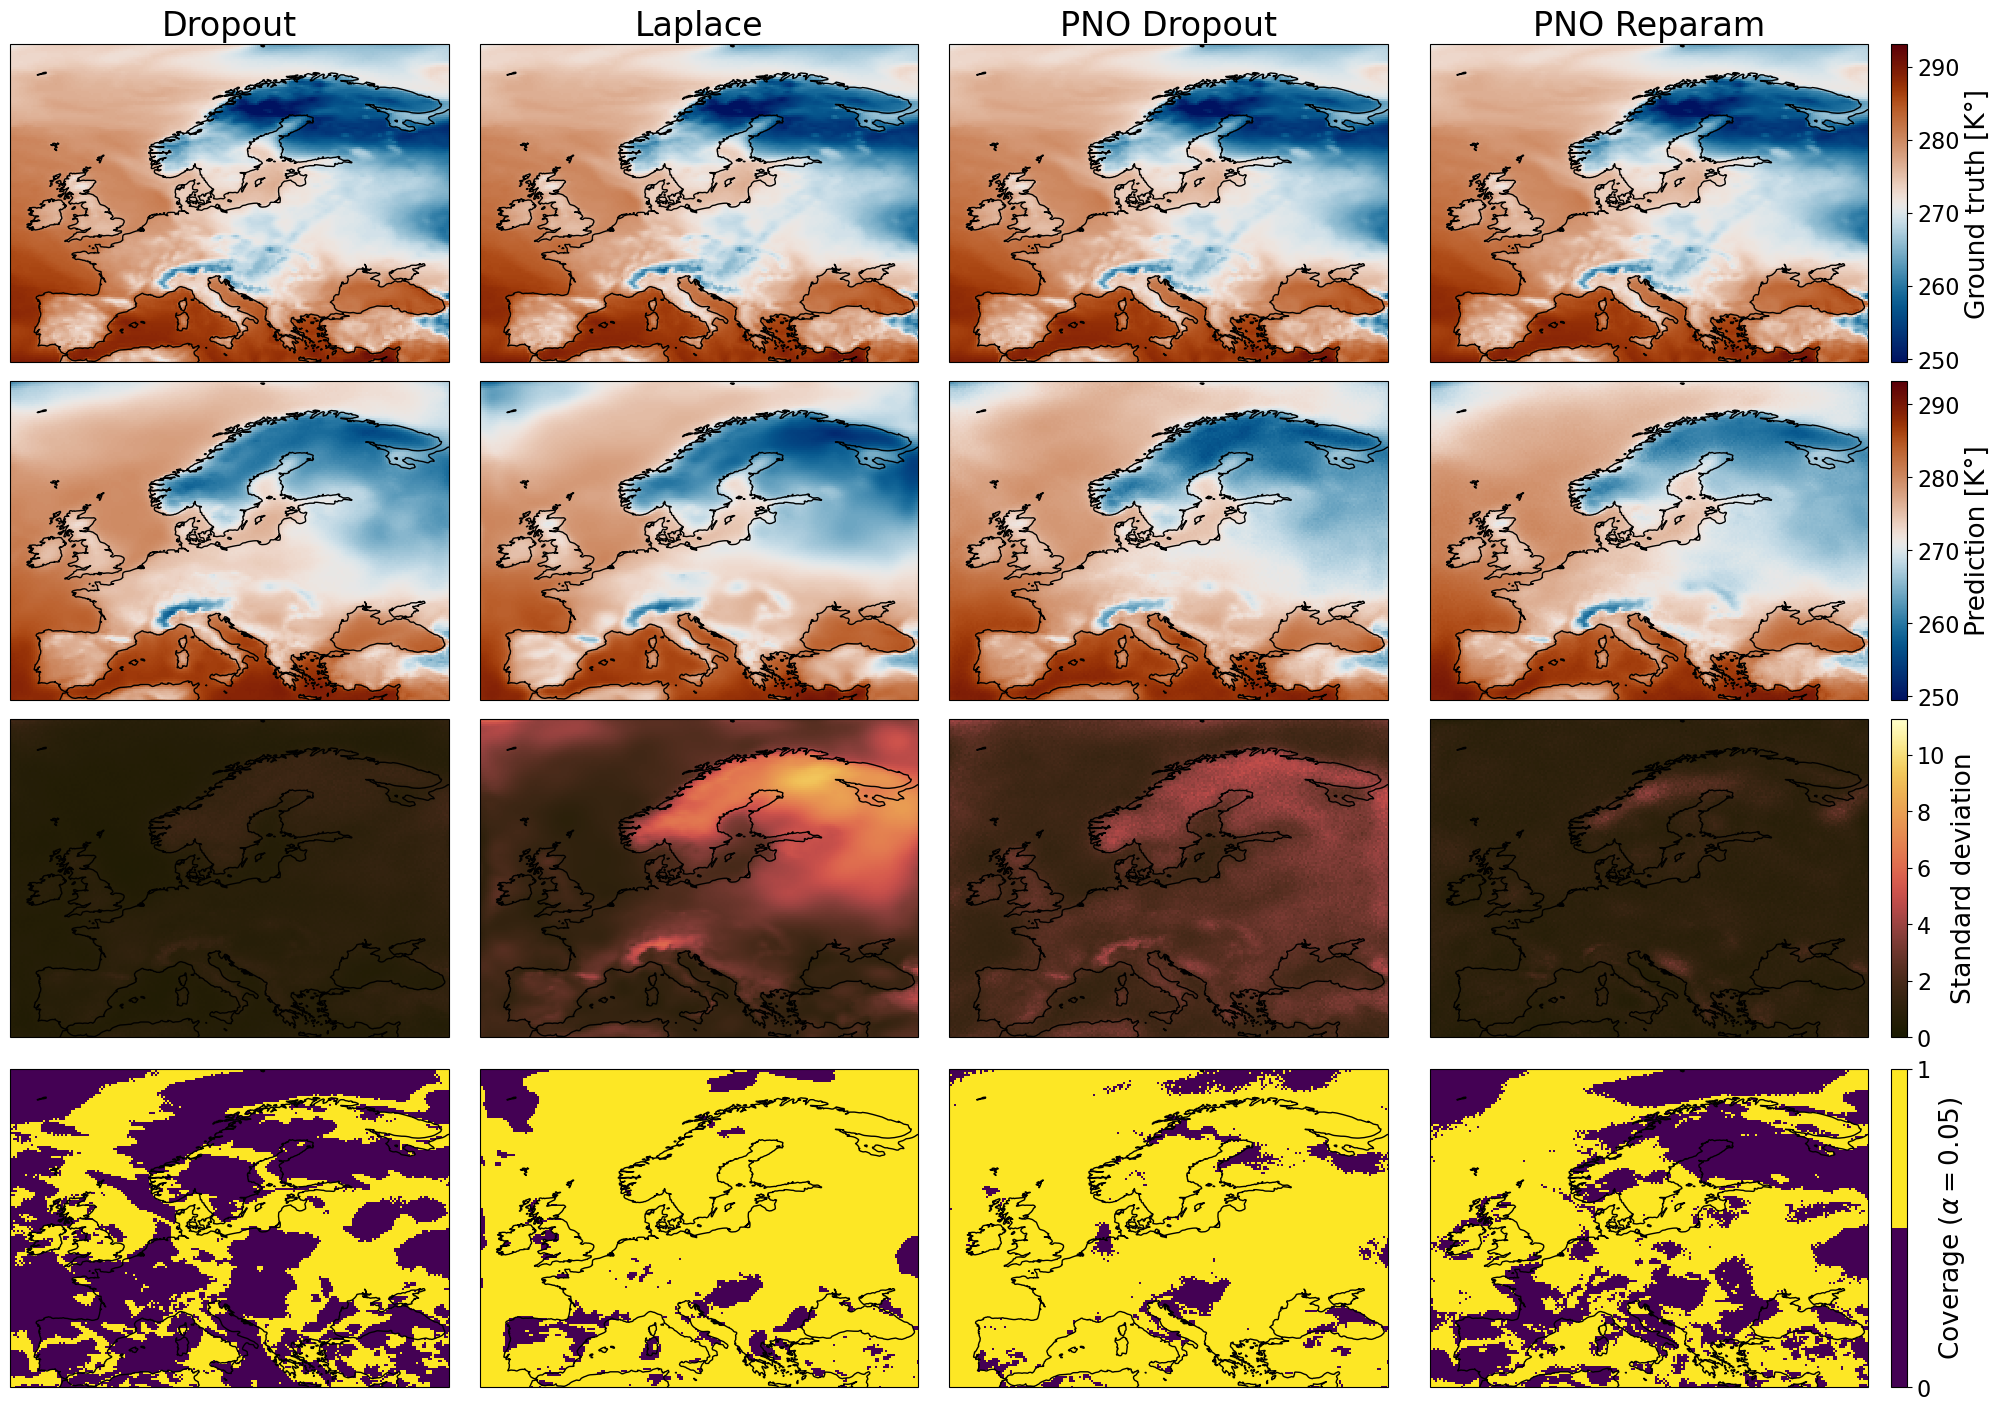

In [27]:
plot_predictions(u, preds, names, (lat,lon), t = 9, save_path = "plots/era5_predictions_10h.pdf", alpha = 0.05)

# Plot CRPS values

In [28]:
class CRPS(object):
    def __init__(self, reduction="mean", reduce_dims=True, **kwargs):
        super().__init__()

        self.reduction = reduction
        self.reduce_dims = reduce_dims

    def reduce(self, x):
        if self.reduction == "sum":
            x = torch.sum(x, dim=0, keepdim=True)
        else:
            x = torch.mean(x, dim=0, keepdim=True)
        return x

    def calculate_score(self, x, y):
        """Calculates the energy score for different metrics

        Args:
            x (_type_): Model prediction (Batch size, ..., n_samples)
            y (_type_): Target (Batch size, ..., 1)
            h (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: Energy score
        """
        n_samples = x.size()[-1]

        # Add additional dimension if necessary
        if len(x.size()) != len(y.size()):
            y = torch.unsqueeze(y, dim=-1)

        # Flatten tensors
        x_flat = torch.flatten(x, start_dim=1, end_dim=-2)
        y_flat = torch.flatten(y, start_dim=1, end_dim=-2)

        # Calculate CRPS
        term_1 = torch.abs(x_flat - y_flat).mean(dim = -1)
        term_2 = torch.abs(
            torch.unsqueeze(x_flat, dim=-1) - torch.unsqueeze(x_flat, dim=-2)
        ).mean(dim = (-2,-1))
        score = term_1 - 0.5*term_2 
        if self.reduce_dims:
            # Aggregate CRPS over spatial dimensions
            score = score.mean(dim = -1)

        # Reduce
        return self.reduce(score).squeeze() if self.reduce_dims else score

    def __call__(self, y_pred, y, **kwargs):
        return self.calculate_score(y_pred, y, **kwargs)

In [29]:
crps = CRPS(reduce_dims = False)
with torch.no_grad():    
    sample = samples[idx]
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    
    dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples).cpu()
    pfno_pred = pfno_model(a, n_samples = n_samples).cpu()
    la_pred = la_model.predictive_samples(a).cpu()
    u = u.cpu()

NameError: name 'pfno_model' is not defined

In [ ]:
pfno_crps = crps(pfno_pred, u).reshape(u.shape)
dropout_crps = crps(dropout_pred, u).reshape(u.shape)
la_crps = crps(la_pred, u).reshape(u.shape)

In [ ]:
preds = [pfno_crps, la_crps, dropout_crps]
names = ['PFNO', 'LA', "Dropout"]

In [ ]:
print(pfno_crps.mean().item(), la_crps.mean().item(), dropout_crps.mean().item())

0.019240833818912506 0.018803533166646957 0.019140245392918587


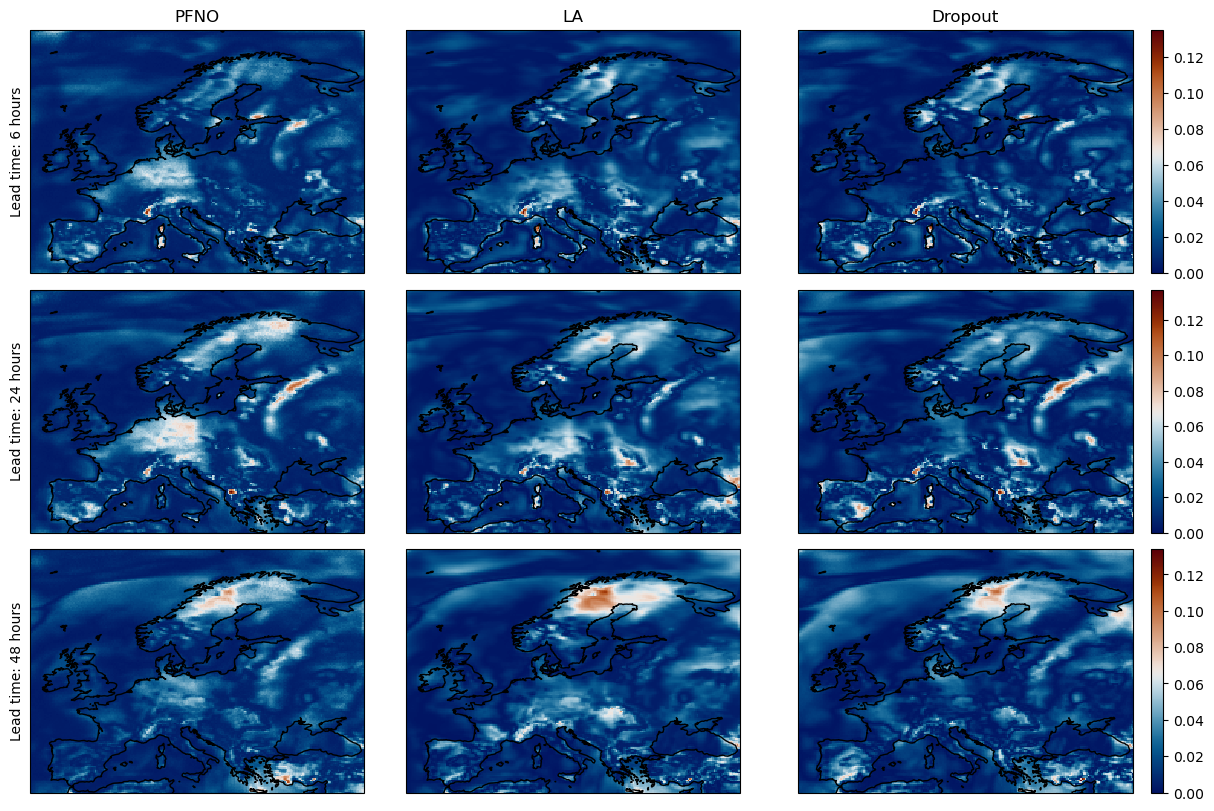

In [ ]:
times = [0,3,7]

pred_array = np.array(preds)


fig, axs = plt.subplots(3,3, figsize = (12,8),subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
for ax in axs.ravel():
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)

for t, time in enumerate(times):
    crps_norm = Normalize(vmin = 0, vmax = pred_array[:,:,:,t].max())
    for m, pred in enumerate(preds):        
        pred = pred[:,:,t].squeeze()
        im1 = axs[t,m].pcolormesh(lon, lat ,pred, shading = "nearest", cmap = "cmc.vik", norm = crps_norm)
        axs[0,m].set_title(names[m])
    fig.colorbar(im1, ax = axs[t,m])     
    axs[t,0].set_ylabel(f"Lead time: {6*(time+1)} hours")       

    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])
    axs[2,0].set_xticks([])
    axs[2,0].set_yticks([])

plt.savefig("plots/era5_crps.png", dpi = 300, bbox_inches = "tight")